<a href="https://colab.research.google.com/github/js-iMore/Analitica_tareas/blob/master/Fifa_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras

tf.__version__

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


'2.1.0'

##Carga de archivos y librerias principales

In [0]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%matplotlib inline
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id1 = '1tsG4T9xFcuYO9hKRWQ7LQ-CCLFYFx_o8' #Base de datos
csv_path = drive.CreateFile({'id': file_id1})
csv_path.GetContentFile('data.csv') 

file_id2 = '1RJQ7Ukb847Ee3QYQPGZtJ3x0obX8vm_1'
funcionesF = drive.CreateFile({'id': file_id2})
funcionesF.GetContentFile('funciones_fifa.py') #Funciones

file_id3 = '1ZhXi77_w01GJIXMcoeGwu_r9dtnpWBRw'
fotos = drive.CreateFile({'id': file_id3})
fotos.GetContentFile('Photos.zip') #fotos de los jugadores

img_path = ''
Main_data = pd.read_csv('data.csv') #Cargar dataset

#Main_data.info()

In [0]:
import zipfile

zipfilename = "Photos.zip"
password = None

# open and extract all files in the zip
z = zipfile.ZipFile(zipfilename, "r")
try:
    z.extractall(pwd=password)
except:
    print('Error')
    pass
z.close()

#Acondicionamiento de los datos

In [0]:
#Clasificación, 2 - Bueno , 1 - Regular , 0 - Malo
Xdata_pre = Main_data
y_class = np.zeros(Xdata_pre.shape[0])
for i in range(Xdata_pre.shape[0]):
        if(Xdata_pre.ix[i]['Overall'] < 50):
            y_class[i] = 0
        elif(50 <= Xdata_pre.ix[i]['Overall'] <= 70):
            y_class[i] = 1
        elif(Xdata_pre.ix[i]['Overall'] > 70):
            y_class[i] = 2

Main_data['Valoracion'] = y_class

In [0]:
#Partición del conjunto
Xtrain, Xtest = train_test_split(Main_data,test_size=0.3)
Xtrain , Xval = train_test_split(Xtrain, test_size=0.3)

col2_delete = ["Value" , "Valoracion" , "Photo" , "Club Logo" , "Flag" , "Real Face"] #Columnas a remover
ytrain = Xtrain[col2_delete[0]]
ytest = Xtest[col2_delete[0]]
yval = Xval[col2_delete[0]]

ytrain_class = Xtrain[col2_delete[1]]
ytest_class = Xtest[col2_delete[1]]
yval_class = Xval[col2_delete[1]]

Xtrain.drop(columns=col2_delete,inplace=True) #Inplace para actualizar el cambio
Xtest.drop(columns=col2_delete,inplace=True)
Xval.drop(columns=col2_delete,inplace=True)

In [6]:
ytest_class

30       2.0
15507    1.0
9061     1.0
18047    1.0
15591    1.0
        ... 
4142     2.0
10039    1.0
17391    1.0
16607    1.0
14188    1.0
Name: Valoracion, Length: 5463, dtype: float64

In [7]:
from funciones_fifa import change_dataY , change_dataX

ytrain = change_dataY(ytrain)
ytest = change_dataY(ytest)
yval = change_dataY(yval)

Xtrain = change_dataX(Xtrain)
Xtest = change_dataX(Xtest)
Xval = change_dataX(Xval)

Xtrain

#Acomodar datos al remover elementos como el símbolo de Euro del conjunto Y

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
6827,6827,202548,L. Puyo,29,France,68,68,Angers SCO,10000,1837,Left,1.0,3.0,3.0,Medium/ Medium,Normal,LW,21.0,"Jul 12, 2017",NaN,2019,182.882224,170,63.2,63.2,63.2,67.2,66.2,66.2,66.2,67.2,68.2,68.2,68.2,68.2,67.2,67.2,67.2,68.2,64.2,...,62.2,59.2,59.2,59.2,62.2,69.0,60.0,58.0,71.0,57.0,70.0,61.0,72.0,70.0,72.0,64.0,63.0,76.0,67.0,69.0,56.0,61.0,82.0,66.0,57.0,69.0,45.0,68.0,67.0,40.0,63.0,51.0,60.0,59.0,16.0,11.0,9.0,10.0,11.0,10000
7200,7200,202896,M. Ureña,28,Costa Rica,68,68,Los Angeles FC,4000,1749,Right,1.0,3.0,3.0,High/ High,Normal,ST,21.0,"Dec 12, 2017",NaN,2019,155.449890,154,66.2,66.2,66.2,68.2,67.2,67.2,67.2,68.2,66.2,66.2,66.2,66.2,61.2,61.2,61.2,66.2,55.2,...,52.2,49.2,49.2,49.2,52.2,57.0,65.0,55.0,64.0,62.0,70.0,49.0,59.0,46.0,69.0,78.0,79.0,82.0,68.0,71.0,65.0,42.0,68.0,70.0,64.0,75.0,39.0,67.0,64.0,60.0,65.0,29.0,41.0,31.0,12.0,10.0,14.0,10.0,14.0,4000
7783,7783,245790,Paulo Henrique,20,Brazil,67,74,Portimonense SC,3000,1612,Right,1.0,4.0,3.0,Medium/ Medium,Lean,RW,98.0,"Aug 31, 2018",NaN,2019,173.738113,137,60.2,60.2,60.2,67.2,65.2,65.2,65.2,67.2,65.2,65.2,65.2,67.2,60.2,60.2,60.2,67.2,52.2,...,48.2,37.2,37.2,37.2,48.2,64.0,63.0,31.0,65.0,47.0,71.0,61.0,46.0,68.0,70.0,84.0,82.0,78.0,59.0,86.0,61.0,56.0,68.0,44.0,45.0,47.0,31.0,64.0,57.0,51.0,41.0,17.0,29.0,26.0,6.0,13.0,6.0,9.0,7.0,3000
6609,6609,182270,W. Sandilands,34,South Africa,69,69,Orlando Pirates,1000,1135,Right,1.0,3.0,1.0,Medium/ Medium,Normal,GK,30.0,"Jul 13, 2017",NaN,2020,155.754694,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,11.0,11.0,19.0,11.0,11.0,10.0,12.0,21.0,35.0,50.0,56.0,57.0,61.0,45.0,11.0,75.0,26.0,72.0,11.0,46.0,22.0,12.0,14.0,37.0,62.0,17.0,15.0,10.0,66.0,73.0,67.0,70.0,68.0,1000
10987,10987,243714,E. Abedini,19,Switzerland,64,78,FC Lugano,1000,1589,Right,1.0,3.0,2.0,Low/ Medium,Lean,CDM,34.0,"Jul 1, 2017",NaN,2021,192.026335,168,50.2,50.2,50.2,55.2,53.2,53.2,53.2,55.2,55.2,55.2,55.2,58.2,59.2,59.2,59.2,58.2,62.2,...,61.2,61.2,61.2,61.2,61.2,61.0,35.0,53.0,63.0,32.0,59.0,42.0,38.0,64.0,62.0,64.0,63.0,63.0,62.0,53.0,48.0,64.0,69.0,65.0,33.0,63.0,64.0,38.0,58.0,47.0,51.0,57.0,64.0,57.0,10.0,7.0,9.0,15.0,7.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3209,204542,Y. Yotún,28,Peru,73,73,Orlando City SC,8000,1974,Left,1.0,1.0,3.0,Medium/ High,Stocky,LDM,19.0,"Aug 4, 2017",NaN,2019,176.786150,150,64.2,64.2,64.2,69.2,68.2,68.2,68.2,69.2,70.2,70.2,70.2,71.2,72.2,72.2,72.2,71.2,70.2,...,68.2,65.2,65.2,65.2,68.2,74.0,50.0,53.0,75.0,61.0,72.0,69.0,69.0,75.0,73.0,68.0,63.0,83.0,70.0,77.0,75.0,77.0,85.0,59.0,64.0,79.0,62.0,66.0,77.0,51.0,74.0,69.0,63.0,66.0,7.0,8.0,16.0,11.0,7.0,8000
12272,12272,203316,A. Smith,25,England,63,65,Bristol Rovers,2000,946,Right,1.0,2.0,1.0,Medium/ Medium,Normal,GK,21.0,"Jul 6, 2017",NaN,2019,188.978298,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.0,12.0,19.0,24.0,12.0,16.0,18.0,19.0,22.0,23.0,24.0,20.0,38.0,58.0,32.0,25.0,44.0,29.0,25.0,17.0,14.0,16.0

In [0]:
#Separación de las imágenes en conjuntos correspondientes a los ID de cada jugador
import cv2
def img_classi(X,path):
    index =np.array(X['Unnamed: 0'])
    X_images = np.zeros((X.shape[0],48,48,3),dtype=np.uint8)
    for im in range(len(index)):
        path_ = path+str(index[im])+'.png'
        X_images[im,:,:,:] = cv2.imread(path_)
       
    return X_images/255.

Xtrain_img = img_classi(Xtrain, 'images/')
Xtest_img = img_classi(Xtest, 'images/')
Xval_img = img_classi(Xval, 'images/')

In [0]:
from funciones_fifa import dummy_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

impt = SimpleImputer(strategy = "median")
ytrain = impt.fit_transform(pd.DataFrame(ytrain)) 
ytest = impt.transform(pd.DataFrame(ytest))  #Los datos pandas, Dataframe 
yval = impt.transform(pd.DataFrame(yval)) 

ytrain_class = impt.fit_transform(pd.DataFrame(ytrain_class)) 
ytest_class = impt.transform(pd.DataFrame(ytest_class))  #Los datos pandas, Dataframe 
yval_class = impt.transform(pd.DataFrame(yval_class)) 


preproceso = dummy_transformer()
norm = StandardScaler()

Xtrain = preproceso.fit_transform(Xtrain)
Xval = preproceso.transform(Xval)

Xtrain = norm.fit_transform(Xtrain)
Xval = norm.transform(Xval)

Xtest = preproceso.transform(Xtest)
Xtest = norm.transform(Xtest)


#Creación de los modelos independientes y unión

In [0]:
keras.backend.clear_session() #Reinicio de variables
np.random.seed(42)  #Guardando posición de los pesos
tf.random.set_seed(42)

In [0]:
#Modelo regresión

input_1 = keras.layers.Input(shape= (Xtrain.shape[1], ))
hiddenR1 = keras.layers.Dense(600, activation="linear")(input_1)
hiddenR2 = keras.layers.Dense(300, activation="sigmoid")(hiddenR1)
hiddenR3 = keras.layers.Dense(200, activation="tanh")(hiddenR2)
hiddenR4 = keras.layers.Dense(100, activation="sigmoid")(hiddenR3)


#Modelo con imágenes
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

input_2 = keras.layers.Input(shape=(48,48,3))
hiddenI = DefaultConv2D(filters=64, kernel_size=7)(input_2)
hiddenI1 = keras.layers.MaxPooling2D(pool_size=2)(hiddenI)
hiddenI2 = DefaultConv2D(filters=128)(hiddenI1)
hiddenI3 = DefaultConv2D(filters=128)(hiddenI2)
hiddenI4 = keras.layers.MaxPooling2D(pool_size=2)(hiddenI3)
hiddenI5 = DefaultConv2D(filters=256)(hiddenI4)
hiddenI6 = DefaultConv2D(filters=256)(hiddenI5)
hiddenI7 = keras.layers.MaxPooling2D(pool_size=2)(hiddenI6)
hiddenI8 = keras.layers.Flatten()(hiddenI7)
hiddenI9 = keras.layers.Dense(units=128, activation='relu')(hiddenI8)
hiddenI10 = keras.layers.Dropout(0.5)(hiddenI9)
hiddenI11 = keras.layers.Dense(units=64, activation='relu')(hiddenI10)
hiddenI12 = keras.layers.Dropout(0.5)(hiddenI11)
hiddenI13 = keras.layers.Dense(units=3, activation='softmax')(hiddenI12)

concat = keras.layers.Concatenate()([hiddenR4,hiddenI13])

output_1 = keras.layers.Dense(1, activation= "sigmoid", name= "Reg_output")(concat) #Salida de la red de regresión
output_2 = keras.layers.Dense(3, activation="softmax" , name="Img_output")(concat) #Salida de la red de imágenes

In [0]:
#Unir modelos
full_model = keras.Model(inputs=[input_1,input_2] , outputs=[output_1,output_2])

In [0]:
full_model.compile(loss= {"Reg_output" : keras.losses.mae, "Img_output" : keras.losses.sparse_categorical_crossentropy},
              optimizer="rmsprop",
              metrics={"Reg_output": "mae", "Img_output" : "accuracy"})

In [14]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
history = full_model.fit([Xtrain, Xtrain_img],[ytrain,ytrain_class],
                         epochs=15,
                         validation_data=([Xval,Xval_img],[yval,yval_class]))

Train on 8920 samples, validate on 3824 samples
Epoch 1/15
8920/8920 [==============================] - 384s 43ms/sample - loss: 1544810.8582 - Reg_output_loss: 1544350.8750 - Img_output_loss: 0.1624 - Reg_output_mae: 1544810.6250 - Img_output_accuracy: 0.9392 - val_loss: 1616545.9304 - val_Reg_output_loss: 1618759.3750 - val_Img_output_loss: 0.0915 - val_Reg_output_mae: 1616545.7500 - val_Img_output_accuracy: 0.9637
Epoch 2/15
8920/8920 [==============================] - 381s 43ms/sample - loss: 1544810.7868 - Reg_output_loss: 1547991.6250 - Img_output_loss: 0.0946 - Reg_output_mae: 1544810.7500 - Img_output_accuracy: 0.9657 - val_loss: 1616546.0162 - val_Reg_output_loss: 1618759.3750 - val_Img_output_loss: 0.1666 - val_Reg_output_mae: 1616545.7500 - val_Img_output_accuracy: 0.9435
Epoch 3/15
8920/8920 [==============================] - 380s 43ms/sample - loss: 1544810.7637 - Reg_output_loss: 1544396.7500 - Img_output_loss: 0.0760 - Reg_output_mae: 1544811.8750 - Img_output_accuracy: 

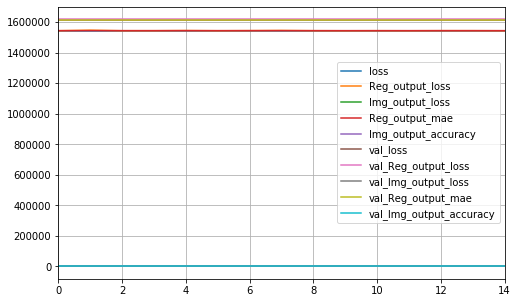

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

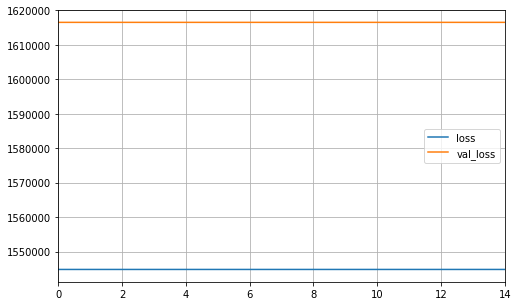

In [19]:
his = pd.DataFrame(history.history)
columns = his.columns

his[[columns[0], columns[5]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

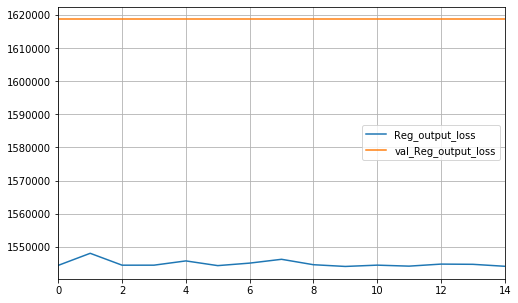

In [20]:
his[[columns[1], columns[6]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

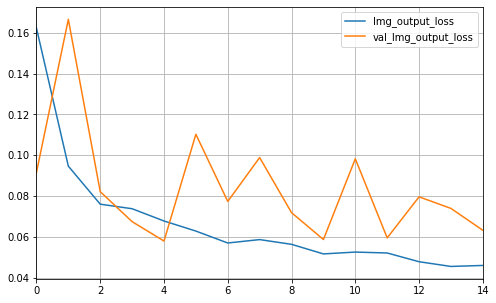

In [21]:
his[[columns[2], columns[7]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

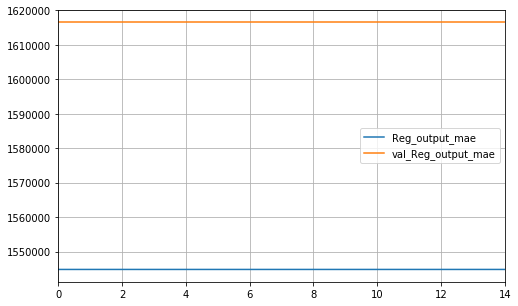

In [22]:
his[[columns[3], columns[8]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

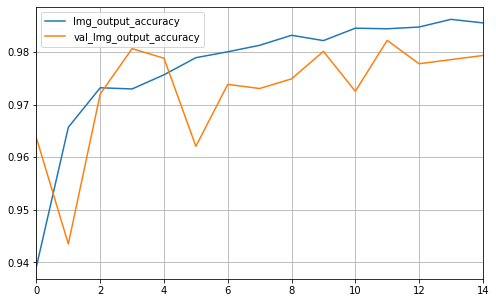

In [23]:
his[[columns[4], columns[9]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()